In [1]:
import pandas as pd 
import numpy as np

import gc
import time
import warnings

#stats
from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss

#시각화
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
import matplotlib_venn as venn
## matplotlib 한글사용
from matplotlib import rc
rc('font', family='AppleGothic')
mpl.rcParams['axes.unicode_minus'] = False

#자연어 처리
import string
import re   #정규표현식
import nltk
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
# Tweet 
from nltk.tokenize import TweetTokenizer   


#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split





#settings
start_time=time.time()
eng_stopwords = set(stopwords.words("english"))
warnings.filterwarnings("ignore")

lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

%matplotlib inline

In [2]:
\₩train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
train.sample(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
65111,ae3669184cca45bc,Free \n\nYou can get it for free from his web ...,0,0,0,0,0,0
105607,35141bc9cf2097b4,"PeartSt82, you are well respected member, Prob...",0,0,0,0,0,0
130487,ba16d2ba50aa3208,lol they changed it cos americans are simpleto...,0,0,0,0,0,0
22069,3a2e89e65f54460c,"""Thanks for reverting vandalism on Los Angeles...",0,0,0,0,0,0
14648,26a552b20bbc4e57,"Man, your civility puts me to shame. Don't be ...",1,0,0,0,0,0
145258,19a3807b35870c6b,"""==added Justice and Development Party==\nTurk...",0,0,0,0,0,0
20553,363f2aaa26c0fb40,"""\n\n Please stop being racist on Wikipedia \n...",0,0,0,0,0,0
100358,1941c91c7fc9ec0f,"""\n\nYou said my article looked like it was """"...",0,0,0,0,0,0
11281,1ddd455effe8957c,"So, I'm not even allowed to tell the truth in ...",0,0,0,0,0,0
44651,775166acfe1acc98,"We're no strangers to love, you know the rules...",0,0,0,0,0,0


 - 독립변수 comment_text

 - 종속변수 6개의 클래스

In [3]:
x=train.iloc[:,2:].sum()
rowsums=train.iloc[:,2:].sum(axis=1)
train['clean']=(rowsums==0)
train['clean'].sum()
print('test set rows :',len(test),'\n')
print("train set rows :",len(train))
print("악플이 아닌 rows  :",train['clean'].sum())
print("악플인     rows  :",int(x.sum()))
train.sample(5)

test set rows : 153164 

train set rows : 159571
악플이 아닌 rows  : 143346
악플인     rows  : 35098


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
11569,1e995a5a4864812f,""" June 2008 (UTC)\n Just a note, they noted CT...",0,0,0,0,0,0,True
42697,71f110b02d4d40df,"""\n\nYes I did notice that Mr Matthew McGhee (...",0,0,0,0,0,0,True
34224,5b5e8ef4c169f51f,I know so well what is written above the edit ...,0,0,0,0,0,0,True
155478,be9324d5aa2af41a,"""::Obvious from this unproductive dialogue why...",0,0,0,0,0,0,True
91767,f5529b9bb5de7e35,"""\n\nPlease do not add nonsense to Wikipedia. ...",0,0,0,0,0,0,True


#### null값 확인

In [4]:
print("train의 null 수 : ")
null_check=train.isnull().sum()
print(null_check)
print("\nTest의 null 수 : ")
null_check=test.isnull().sum()
print(null_check)
train["comment_text"].fillna("unknown", inplace=True)
test["comment_text"].fillna("unknown", inplace=True)

train의 null 수 : 
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
clean            0
dtype: int64

Test의 null 수 : 
id              0
comment_text    0
dtype: int64


#### y값 (클래스 분포) 확인

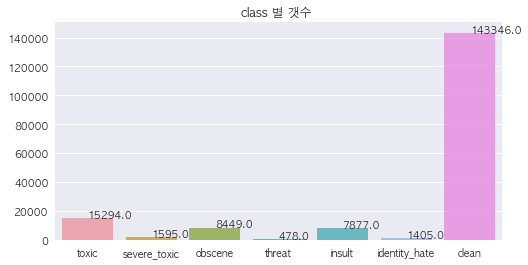

In [5]:
x=train.iloc[:,2:].sum()
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("class 별 갯수 ")
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label)

plt.show()

- 클래스들 분포를 보았을때 규칙을 같아보기 힘들다.


#### 클래스가 어려개인 수 확인

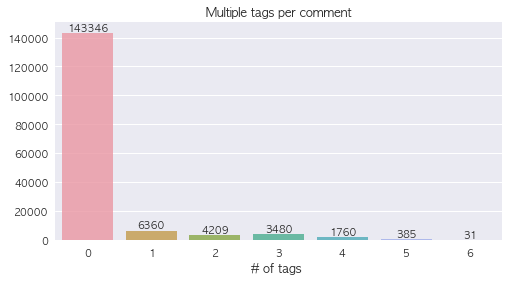

In [6]:
 x=rowsums.value_counts()

#plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Multiple tags per comment")
plt.xlabel('# of tags ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

0은 악플이 아님을 의미한다


#### 클래스들간에 상관관계 확인

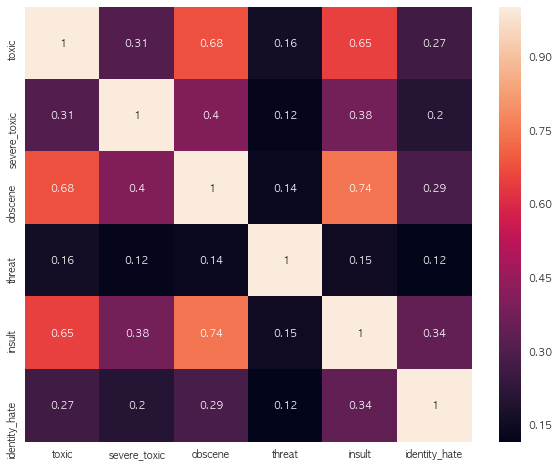

In [7]:
temp_df=train.iloc[:,2:-1]
# filter temp by removing clean comments
# temp_df=temp_df[~train.clean]

corr=temp_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

In [8]:

for other_col in temp_df.columns[1:]:
    confusion_matrix = pd.crosstab(temp_df["toxic"], temp_df[other_col])
    display(confusion_matrix)


severe_toxic,0,1
toxic,,
0,144277,0
1,13699,1595


obscene,0,1
toxic,,
0,143754,523
1,7368,7926


threat,0,1
toxic,,
0,144248,29
1,14845,449


insult,0,1
toxic,,
0,143744,533
1,7950,7344


identity_hate,0,1
toxic,,
0,144174,103
1,13992,1302


- Severe toxic는 항상 toxic이다
- toxic이 아닐때 다른 클래스에 속하는 경우가 매우 적다. toxic이 상위 클래스일 수도 있다

### Wordclouds

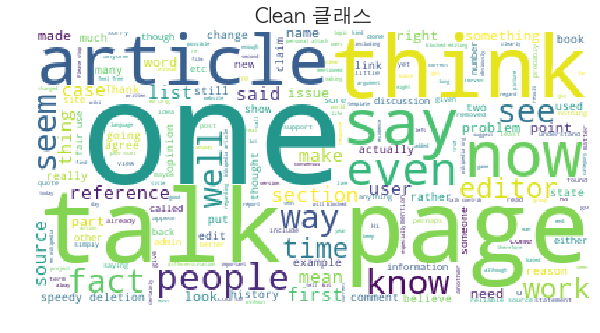

In [9]:
stopword=set(STOPWORDS)

subset=train[train.clean==True]
text=subset.comment_text.values
wc= WordCloud(background_color="white",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Clean 클래스", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

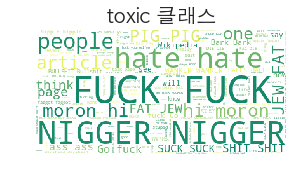

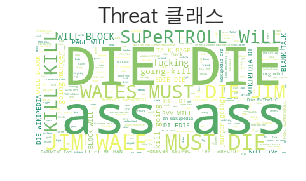

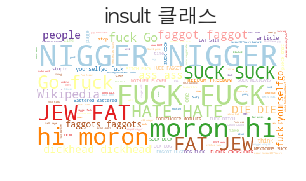

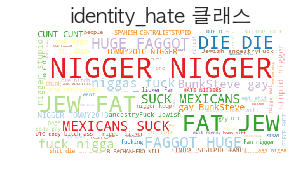

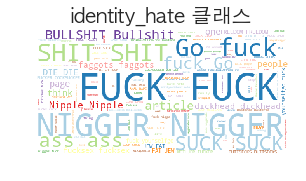

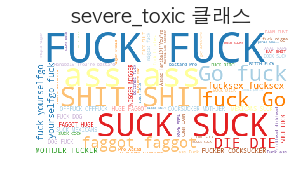

In [10]:
subset=train[train.toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="white",max_words=4000,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(10,10))
plt.subplot(3,2,1)
plt.axis("off")
plt.title("toxic 클래스", fontsize=20)
plt.imshow(wc.recolor(colormap= 'summer' , random_state=123), alpha=0.98)

subset=train[train.threat==1]
text=subset.comment_text.values
wc= WordCloud(background_color="white",max_words=4000,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(10,10))
plt.subplot(3,2,2)
plt.axis("off")
plt.title("Threat 클래스", fontsize=20)
plt.imshow(wc.recolor(colormap= 'summer' , random_state=423), alpha=0.98)

subset=train[train.insult==1]
text=subset.comment_text.values
wc= WordCloud(background_color="white",max_words=4000,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(10,10))
plt.subplot(3,2,3)
plt.axis("off")
plt.title("insult 클래스", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Paired_r' , random_state=244), alpha=0.98)

subset=train[train.identity_hate==1]
text=subset.comment_text.values
wc= WordCloud(background_color="white",max_words=4000,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(10,10))
plt.subplot(3,2,4)
plt.axis("off")
plt.title("identity_hate 클래스", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Paired_r' , random_state=35), alpha=0.98)

subset=train[train.obscene==1]
text=subset.comment_text.values
wc= WordCloud(background_color="white",max_words=4000,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(10,10))
plt.subplot(3,2,5)
plt.axis("off")
plt.title("identity_hate 클래스", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Paired_r' , random_state=231), alpha=0.98)

subset=train[train.severe_toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="white",max_words=4000,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(10,10))
plt.subplot(3,2,6)
plt.axis("off")
plt.title("severe_toxic 클래스", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Paired_r' , random_state=54), alpha=0.98)

plt.show()

In [11]:
# train test 합치기
merge=pd.concat([train.iloc[:,0:2],test.iloc[:,0:2]])
df=merge.reset_index(drop=True)
df.tail()

,id,comment_text
312730,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
312731,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
312732,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
312733,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."
312734,ffffce3fb183ee80,""" \n :::Stop already. Your bullshit is not wel..."


#### 댓글의 특징을 나타내는 피쳐들 추가

In [12]:
df['count_sent']=df["comment_text"].apply(lambda x: len(re.findall("\n",str(x)))+1)
df['count_word']=df["comment_text"].apply(lambda x: len(str(x).split()))
df['count_unique_word']=df["comment_text"].apply(lambda x: len(set(str(x).split())))
df['count_len']=df["comment_text"].apply(lambda x: len(str(x)))
df["count_punctuations"] =df["comment_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
df["count_words_upper"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
df["count_stopwords"] = df["comment_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
df['word_unique_percent']=df['count_unique_word']*100/df['count_word']
df['punct_percent']=df['count_punctuations']*100/df['count_word']

In [13]:
# train test 나누기
train_feats=df.iloc[0:len(train),]
test_feats=df.iloc[len(train):,]
# 만든 피쳐들을 합친 train 데이터 만들기
train_makecol=train.iloc[:,2:]
train_feats=pd.concat([train_feats,train_makecol],axis=1)

In [14]:
train_feats.sample(5)

,id,comment_text,count_sent,count_word,count_unique_word,count_len,count_punctuations,count_words_upper,count_stopwords,word_unique_percent,punct_percent,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
142097,f824b47f7960106b,Template parameters\nDefiantly date= is the wa...,3,131,100,718,38,9,59,76.335878,29.007634,0,0,0,0,0,0,True
159539,ff9ae4a64d2d5de1,The table is fixed as well. Remember that thes...,1,43,41,259,9,1,15,95.348837,20.930233,0,0,0,0,0,0,True
133265,c8fab0122a72d2d2,"""\nI did not neglect to mention reliable sourc...",2,162,107,934,39,2,80,66.049383,24.074074,0,0,0,0,0,0,True
26623,4689b8f0a247368e,""" March 2009 (UTC)\n\nYes I agree that what ma...",3,78,66,442,16,5,35,84.615385,20.512821,0,0,0,0,0,0,True
35019,5d859ff1d2e615a5,"""\n\n Edit request on 17 June 2013 \n\nChoudar...",7,57,46,337,10,0,20,80.701754,17.543860,0,0,0,0,0,0,True


### 글의 길이로 악플인지 판단할 수 있을까?

긴글이 악플이 많은지 확인


Text(0.5,1,'문장수의 따른 악플여부')

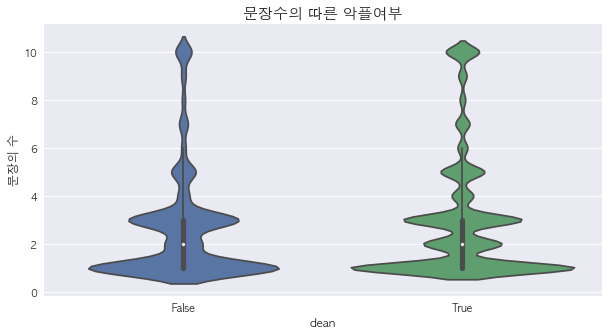

In [15]:
# 최대값을 10으로 부여
train_feats['count_sent'].loc[train_feats['count_sent']>10] = 10

plt.figure(figsize=(10,5))
print('긴글이 악플이 많은지 확인')
sns.violinplot(y='count_sent',x='clean', data=train_feats,split=True)

plt.ylabel('문장의 수', fontsize=12)
plt.title("문장수의 따른 악플여부", fontsize=15)

Text(0.5,1,'단어의 수에 따른 악플여부')

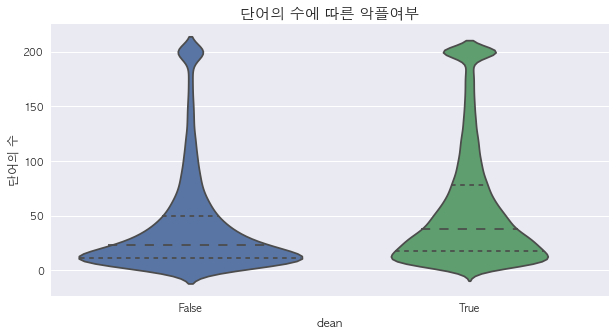

In [16]:
# 최대값은 200으로 부여
train_feats['count_word'].loc[train_feats['count_word']>200] = 200

plt.figure(figsize=(10,5))
sns.violinplot(y='count_word',x='clean', data=train_feats,split=True,inner="quart")

plt.ylabel('단어의 수', fontsize=12)
plt.title("단어의 수에 따른 악플여부", fontsize=15)

- 글의 길이 대한 특징은 중요하지 않아 보인다

#### 스팸댓글을 찾아보자

In [17]:
# 반복적인 단어가 많으면 스팸으로 판단
spammers=train_feats[train_feats['word_unique_percent']<30]

In [18]:
spammers.sample(5)

,id,comment_text,count_sent,count_word,count_unique_word,count_len,count_punctuations,count_words_upper,count_stopwords,word_unique_percent,punct_percent,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
128198,ad9e1ffdca414602,I DONT CARE I DONT CARE I DONT CARE I DONT CAR...,1,200,3,4151,0,1038,346,0.289017,0.000000,1,0,0,0,0,0,False
61427,a46da9f0b58b26b2,RAPE RAPE RAPE RAPE RAPE RAPE RAPE RAPE RAPE R...,1,148,1,739,0,148,0,0.675676,0.000000,1,0,0,0,0,0,False
131981,c24719adc1207e0c,UR SUCH STUPID U IDIOT \n\nI HATE U I HATE U I...,3,200,8,1313,0,434,144,1.839080,0.000000,1,0,0,0,0,0,False
142181,f88452eed30da5b6,Capital Tokushima (city) \nRegion Shikoku \nIs...,10,200,21,3211,252,0,0,4.545455,54.545455,0,0,0,0,0,0,True
6911,12703d55c77ed5b1,SHUT THE FUCK UP!\nSHUT THE FUCK UP!\nSHUT THE...,10,200,5,937,52,207,52,2.403846,25.000000,1,1,1,0,1,0,False


In [19]:
train_feats['count_unique_word'].loc[train_feats['count_unique_word']>200] = 200
temp_df = pd.melt(train_feats, value_vars=['count_word', 'count_unique_word'], id_vars='clean')


In [20]:
temp_df.tail()

,clean,variable,value
319137,True,count_unique_word,44
319138,True,count_unique_word,18
319139,True,count_unique_word,12
319140,True,count_unique_word,23
319141,True,count_unique_word,32


Text(0.5,1,'(왼)전체 단어수의 악플여부 / (오)유니크한 단어수의 악플여부')

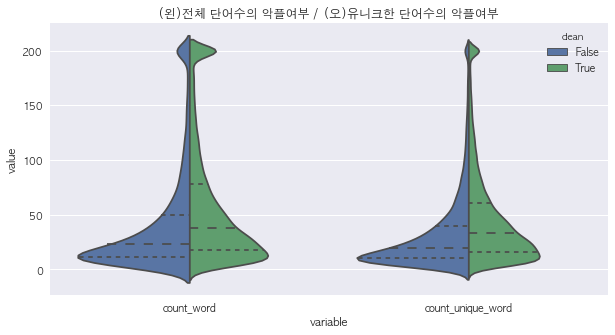

In [21]:
plt.figure(figsize=(10,5))

sns.violinplot(x='variable', y='value', hue='clean', data=temp_df,split=True,inner='quartile')
plt.title("(왼)전체 단어수의 악플여부 / (오)유니크한 단어수의 악플여부")

Text(0.5,0,'유니크한 단어의 비율')

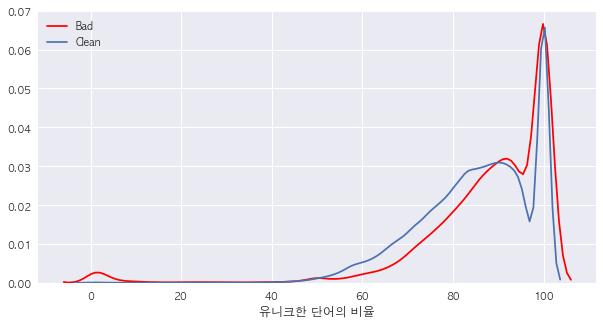

In [22]:
plt.figure(figsize=(10,5))

ax=sns.kdeplot(train_feats[train_feats.clean == 0].word_unique_percent, label="Bad",color='r')
ax=sns.kdeplot(train_feats[train_feats.clean == 1].word_unique_percent, label="Clean")
plt.legend()

plt.xlabel('유니크한 단어의 비율', fontsize=12)

스팸글의 수 :  471


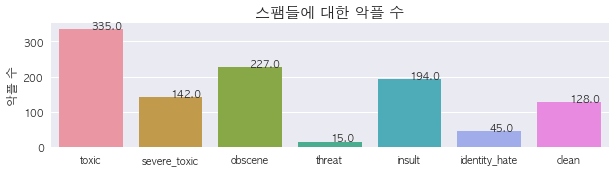

In [23]:
plt.figure(figsize=(10,5))

x=spammers.iloc[:,-7:].sum()
plt.subplot2grid((2,2),(1,0),colspan=2)
plt.title("스팸들에 대한 악플 수",fontsize=15)
ax=sns.barplot(x=x.index, y=x.values)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height, label)

print('스팸글의 수 : ',len(spammers))
plt.ylabel('악플 수', fontsize=12)
plt.show()

- 스팸은 라벨링이 되어있지 않아 아쉽다

In [24]:
print("명백히 악플인데 악플로 분류되지 않은 글 :")
print(spammers[spammers.clean==1].comment_text.iloc[20])

명백히 악플인데 악플로 분류되지 않은 글 :
UNBLOCK SHANNON! ===     === UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON

In [25]:
df['ip']=df["comment_text"].apply(lambda x: re.findall("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",str(x)))
df['count_ip']=df["ip"].apply(lambda x: len(x))

df['link']=df["comment_text"].apply(lambda x: re.findall("http://.*com",str(x)))
df['count_links']=df["link"].apply(lambda x: len(x))

df['article_id']=df["comment_text"].apply(lambda x: re.findall("\d:\d\d\s{0,5}$",str(x)))
df['article_id_flag']=df.article_id.apply(lambda x: len(x))

df['username']=df["comment_text"].apply(lambda x: re.findall("\[\[User(.*)\|",str(x)))
df['count_usernames']=df["username"].apply(lambda x: len(x))


### text 데이터 전처리

In [26]:
corpus=merge.comment_text

In [27]:
appos = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":"we will",
"didn't": "did not"
}

In [28]:
def clean(comment):
    """
    This function receives comments and returns clean word-list
    """
    #소문자로 바꾼후, sub을 사용해 ""로 치환
    comment=comment.lower()
    comment=re.sub("\\n","",comment)
    comment=re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",comment)
    comment=re.sub("\[\[.*\]","",comment)
    
    #tokenize, 문장을 나눕니다
    words=tokenizer.tokenize(comment)
    
    words=[appos[word] if word in appos else word for word in words]
    words=[lem.lemmatize(word, "v") for word in words]
    words = [w for w in words if not w in eng_stopwords]
    
    clean_sent=" ".join(words)
    return(clean_sent)

#### 함수 테스트

In [29]:
corpus.iloc[123456]


'"\n\nI\'ve tried to explain to you problems with statements like ""all mainstream jewish groups oppose jews for jesus"".   If you can\'t understand this I\'m not sure where else this can go.   Perhaps you might benefit from visiting the talk page off WP:NPOV and some other editor can explain why this is not permissibile at wiki.   Their are indeed many pov-pushing elements to this page.   Things like the gigantic ""Christianity"" template used to ""warn"" people abot this group.\nAs far as the blockquote, the combination of footnotes  and poor writing seemed to indicate it wasn\'t a quote.  It isn\'t appropriate to insert footnotes into someone else\'s quote  if he wants he\'ll create his own footnotes.  Cleaning up someone else\'s writing isn\'t POV.   The citation itself is a rewriting of the j4j belief statement.   And in this case, it is necessary: no self-respecting professional would use a phrase like ""basically indistibuishable"".     "'

In [30]:
clean(corpus.iloc[123456])

'" I have try explain problems statements like " " mainstream jewish group oppose jews jesus " " . cannot understand I am sure else go . perhaps might benefit visit talk page wp : npov editor explain permissibile wiki . indeed many pov-pushing elements page . things like gigantic " " christianity " " template use " " warn " " people abot group.as far blockquote , combination footnote poor write seem indicate was not quote . is not appropriate insert footnote someone else\'s quote want he will create footnote . clean someone else\'s write is not pov . citation rewrite j4j belief statement . case , necessary : self-respecting professional would use phrase like " " basically indistibuishable " " . "'

#### 텍스트 전처리

In [31]:
clean_corpus=corpus.apply(lambda x :clean(x))

end_time=time.time()
print("total time till Cleaning",end_time-start_time)

total time till Cleaning 272.49060678482056


In [32]:
train['comment_text'] = clean_corpus[:159571]
test['comment_text'] = clean_corpus[159571:len(clean_corpus)]

In [33]:
tfv = TfidfVectorizer(min_df=200,  max_features=10000, 
            strip_accents='unicode', analyzer='word',ngram_range=(1,1),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')
tfv.fit(clean_corpus)
features = np.array(tfv.get_feature_names())

train_unigrams =  tfv.transform(clean_corpus.iloc[:train.shape[0]])
test_unigrams = tfv.transform(clean_corpus.iloc[train.shape[0]:])

In [34]:
def top_tfidf_feats(row, features, top_n=25):

    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(Xtr, features, grp_ids, min_tfidf=0.1, top_n=25):
    
    D = Xtr[grp_ids].toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

# modified for multilabel milticlass
def top_feats_by_class(Xtr, features, min_tfidf=0.1, top_n=20):
    dfs = []
    cols=train_tags.columns
    for col in cols:
        ids = train_tags.index[train_tags[col]==1]
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [35]:
train_tags=train.iloc[:,2:]
train_feats=pd.concat([train_feats,train_tags],axis=1)
tfidf_top_n_per_lass=top_feats_by_class(train_unigrams,features)

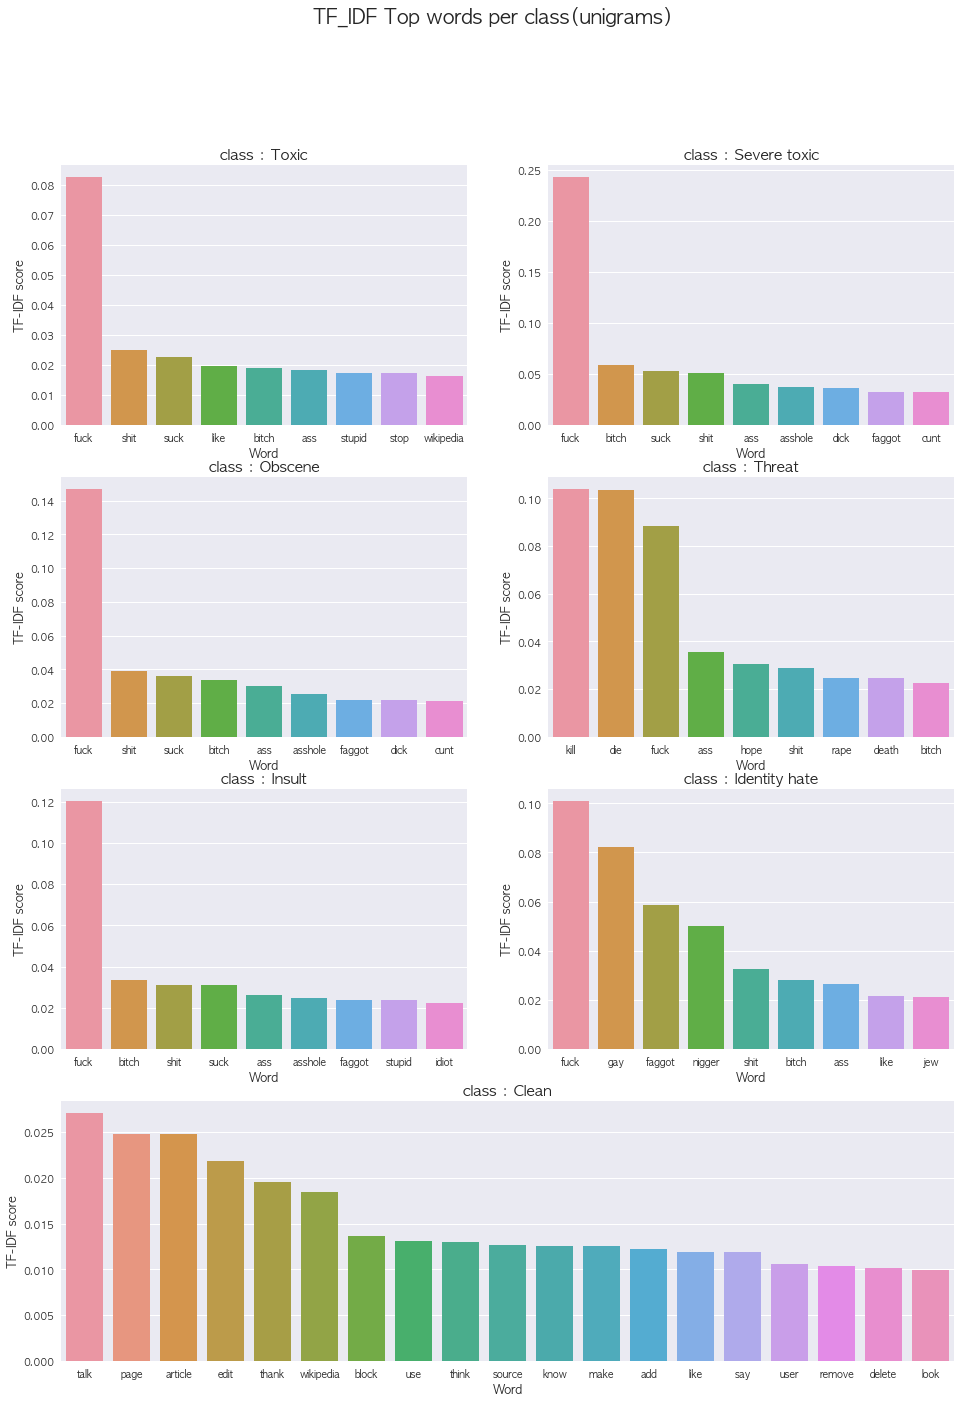

In [36]:
plt.figure(figsize=(16,22))
plt.suptitle("TF_IDF Top words per class(unigrams)",fontsize=20)
gridspec.GridSpec(4,2)
plt.subplot2grid((4,2),(0,0))
sns.barplot(tfidf_top_n_per_lass[0].feature.iloc[0:9],tfidf_top_n_per_lass[0].tfidf.iloc[0:9])
plt.title("class : Toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.subplot2grid((4,2),(0,1))
sns.barplot(tfidf_top_n_per_lass[1].feature.iloc[0:9],tfidf_top_n_per_lass[1].tfidf.iloc[0:9])
plt.title("class : Severe toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,0))
sns.barplot(tfidf_top_n_per_lass[2].feature.iloc[0:9],tfidf_top_n_per_lass[2].tfidf.iloc[0:9])
plt.title("class : Obscene",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,1))
sns.barplot(tfidf_top_n_per_lass[3].feature.iloc[0:9],tfidf_top_n_per_lass[3].tfidf.iloc[0:9])
plt.title("class : Threat",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,0))
sns.barplot(tfidf_top_n_per_lass[4].feature.iloc[0:9],tfidf_top_n_per_lass[4].tfidf.iloc[0:9])
plt.title("class : Insult",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,1))
sns.barplot(tfidf_top_n_per_lass[5].feature.iloc[0:9],tfidf_top_n_per_lass[5].tfidf.iloc[0:9])
plt.title("class : Identity hate",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(3,0),colspan=2)
sns.barplot(tfidf_top_n_per_lass[6].feature.iloc[0:19],tfidf_top_n_per_lass[6].tfidf.iloc[0:19])
plt.title("class : Clean",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.show()

In [37]:
tfv = TfidfVectorizer(min_df=150,  max_features=30000, 
            strip_accents='unicode', analyzer='word',ngram_range=(2,2),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

tfv.fit(clean_corpus)
features = np.array(tfv.get_feature_names())
train_bigrams =  tfv.transform(clean_corpus.iloc[:train.shape[0]])
test_bigrams = tfv.transform(clean_corpus.iloc[train.shape[0]:])
#get top n for bigrams
tfidf_top_n_per_lass=top_feats_by_class(train_bigrams,features)

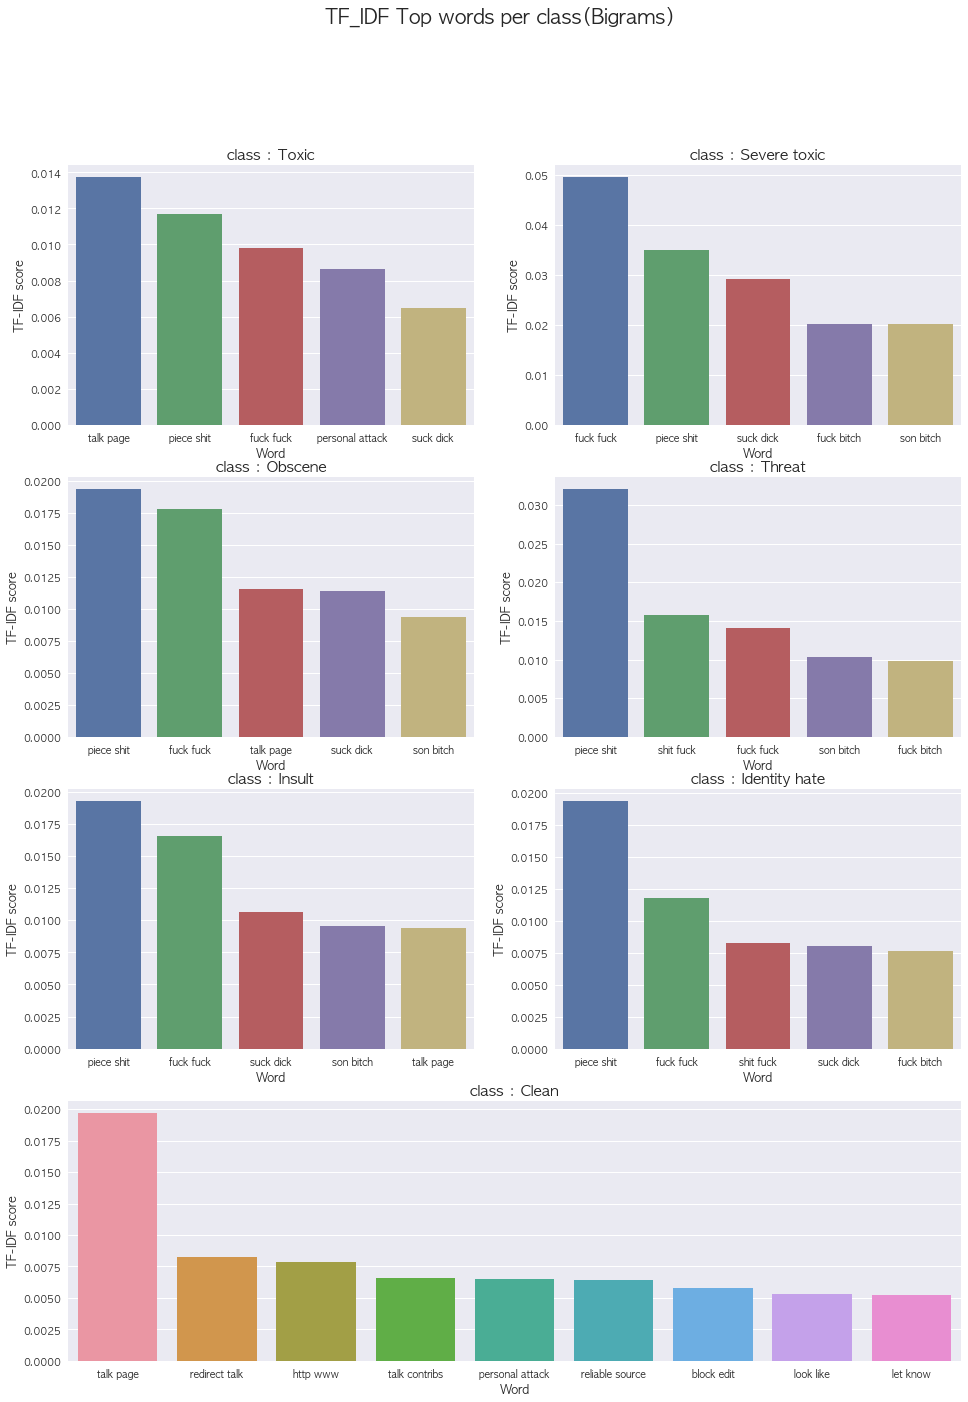

In [38]:
plt.figure(figsize=(16,22))
plt.suptitle("TF_IDF Top words per class(Bigrams)",fontsize=20)
gridspec.GridSpec(4,2)
plt.subplot2grid((4,2),(0,0))
sns.barplot(tfidf_top_n_per_lass[0].feature.iloc[0:5],tfidf_top_n_per_lass[0].tfidf.iloc[0:5])
plt.title("class : Toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.subplot2grid((4,2),(0,1))
sns.barplot(tfidf_top_n_per_lass[1].feature.iloc[0:5],tfidf_top_n_per_lass[1].tfidf.iloc[0:5])
plt.title("class : Severe toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,0))
sns.barplot(tfidf_top_n_per_lass[2].feature.iloc[0:5],tfidf_top_n_per_lass[2].tfidf.iloc[0:5])
plt.title("class : Obscene",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,1))
sns.barplot(tfidf_top_n_per_lass[3].feature.iloc[0:5],tfidf_top_n_per_lass[3].tfidf.iloc[0:5])
plt.title("class : Threat",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,0))
sns.barplot(tfidf_top_n_per_lass[4].feature.iloc[0:5],tfidf_top_n_per_lass[4].tfidf.iloc[0:5])
plt.title("class : Insult",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,1))
sns.barplot(tfidf_top_n_per_lass[5].feature.iloc[0:5],tfidf_top_n_per_lass[5].tfidf.iloc[0:5])
plt.title("class : Identity hate",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(3,0),colspan=2)
sns.barplot(tfidf_top_n_per_lass[6].feature.iloc[0:9],tfidf_top_n_per_lass[6].tfidf.iloc[0:9])
plt.title("class : Clean",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.show()

### Building the model

In [39]:
COMMENT = 'comment_text'

vec = TfidfVectorizer(ngram_range=(2,2), tokenizer=tokenizer.tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )
trn_term_doc = vec.fit_transform(train[COMMENT])
test_term_doc = vec.transform(test[COMMENT])

In [40]:
def pr(y_i, y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

In [41]:
x = trn_term_doc
test_x = test_term_doc
def get_mdl(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    m = LogisticRegression(C=4, dual=True)
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r

In [42]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
preds = np.zeros((len(test), len(label_cols)))

for i, j in enumerate(label_cols):
    print('fit', j)
    m,r = get_mdl(train[j])
    preds[:,i] = m.predict_proba(test_x.multiply(r))[:,1]

fit toxic
fit severe_toxic
fit obscene
fit threat
fit insult
fit identity_hate


In [43]:
subm = pd.read_csv('../input/sample_submission.csv')
submid = pd.DataFrame({'id': subm["id"]})
submission = pd.concat([submid, pd.DataFrame(preds, columns = label_cols)], axis=1)
submission.to_csv('submission_3.csv', index=False)

In [147]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

pipe = make_pipeline(TfidfVectorizer(min_df=1000,  max_features=5000, 
            strip_accents='unicode', analyzer='word',
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english'), LogisticRegression(C=1))
param_grid = {'logisticregression__C': [0.1, 1, 10, 100],
              "tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)]}

grid1 = GridSearchCV(pipe, param_grid, cv=4)
grid1.fit(train.comment_text, train.toxic)
print("최상의 크로스 밸리데이션 점수: {:.2f}".format(grid1.best_score_))
print("최적의 매개변수:\n{}".format(
        grid1.best_params_))

KeyboardInterrupt: 

In [132]:
grid2 = GridSearchCV(pipe, param_grid, cv=4)
grid2.fit(train.comment_text, train.severe_toxic)
print("최상의 크로스 밸리데이션 점수: {:.2f}".format(grid2.best_score_))
print("최적의 매개변수:\n{}".format(
        grid2.best_params_))


최상의 크로스 밸리데이션 점수: 0.99
최적의 매개변수:
{'logisticregression__C': 0.1, 'tfidfvectorizer__ngram_range': (1, 1)}


In [133]:
grid3 = GridSearchCV(pipe, param_grid, cv=4)
grid3.fit(train.comment_text, train.obscene)
print("최상의 크로스 밸리데이션 점수: {:.2f}".format(grid3.best_score_))
print("최적의 매개변수:\n{}".format(
        grid3.best_params_))

최상의 크로스 밸리데이션 점수: 0.97
최적의 매개변수:
{'logisticregression__C': 10, 'tfidfvectorizer__ngram_range': (1, 2)}


In [134]:
grid4 = GridSearchCV(pipe, param_grid, cv=4)
grid4.fit(train.comment_text, train.threat)
print("최상의 크로스 밸리데이션 점수: {:.2f}".format(grid4.best_score_))
print("최적의 매개변수:\n{}".format(
        grid4.best_params_))

최상의 크로스 밸리데이션 점수: 1.00
최적의 매개변수:
{'logisticregression__C': 0.1, 'tfidfvectorizer__ngram_range': (1, 1)}


In [135]:
grid5 = GridSearchCV(pipe, param_grid, cv=4)
grid5.fit(train.comment_text, train.insult)
print("최상의 크로스 밸리데이션 점수: {:.2f}".format(grid5.best_score_))
print("최적의 매개변수:\n{}".format(
        grid5.best_params_))

최상의 크로스 밸리데이션 점수: 0.96
최적의 매개변수:
{'logisticregression__C': 1, 'tfidfvectorizer__ngram_range': (1, 1)}


In [136]:
grid6 = GridSearchCV(pipe, param_grid, cv=4)
grid6.fit(train.comment_text, train.identity_hate)
print("최상의 크로스 밸리데이션 점수: {:.2f}".format(grid6.best_score_))
print("최적의 매개변수:\n{}".format(
        grid6.best_params_))

최상의 크로스 밸리데이션 점수: 0.99
최적의 매개변수:
{'logisticregression__C': 10, 'tfidfvectorizer__ngram_range': (1, 1)}


### submssion만들기(실제 퍼포먼스 확인)

In [137]:
pred_pro1 = grid1.predict_proba(test.comment_text)[:,1]
pred_pro2 = grid2.predict_proba(test.comment_text)[:,1]
pred_pro3 = grid3.predict_proba(test.comment_text)[:,1]
pred_pro4 = grid4.predict_proba(test.comment_text)[:,1]
pred_pro5 = grid5.predict_proba(test.comment_text)[:,1]
pred_pro6 = grid6.predict_proba(test.comment_text)[:,1]

In [138]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
preds = np.zeros((len(test), len(label_cols)))



In [139]:
subm = pd.read_csv('../input/sample_submission.csv')
submid = pd.DataFrame({'id': subm["id"]})

In [140]:
preds[:,0] = pred_pro1
preds[:,1] = pred_pro2
preds[:,2] = pred_pro3
preds[:,3] = pred_pro4
preds[:,4] = pred_pro5
preds[:,5] = pred_pro6


In [141]:
submission = pd.concat([submid, pd.DataFrame(preds, columns = label_cols)], axis=1)
submission.to_csv('submission_5.csv', index=False)

##### 결과 : 0.9167

##### gridsearch 다시하기

In [181]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

pipe = make_pipeline(TfidfVectorizer(#min_df=1000,  max_features=5000, 
            strip_accents='unicode', analyzer='word',ngram_range=(1,1),
            use_idf=1,smooth_idf=1,sublinear_tf=1, stop_words = 'english'), 
            LogisticRegression(C=1))
param_grid = {'tfidfvectorizer__min_df': [10, 15, 25, 30, 40],
              'tfidfvectorizer__max_features': [2000, 4000, 6000, 8000, 10000],
              #"tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (2, 2)]
             }

In [182]:
%%time
grid1 = GridSearchCV(pipe, param_grid, cv=4)
grid1.fit(train.comment_text, train.toxic)
print("최상의 크로스 밸리데이션 점수: {:.4f}".format(grid1.best_score_))
print("최적의 매개변수:\n{}".format(
        grid1.best_params_))

최상의 크로스 밸리데이션 점수: 0.9574
최적의 매개변수:
{'tfidfvectorizer__max_features': 8000, 'tfidfvectorizer__min_df': 30}
CPU times: user 19min 39s, sys: 22.2 s, total: 20min 2s
Wall time: 20min 6s


In [183]:
%%time
grid2 = GridSearchCV(pipe, param_grid, cv=4)
grid2.fit(train.comment_text, train.severe_toxic)
print("최상의 크로스 밸리데이션 점수: {:.4f}".format(grid2.best_score_))
print("최적의 매개변수:\n{}".format(
        grid2.best_params_))


최상의 크로스 밸리데이션 점수: 0.9905
최적의 매개변수:
{'tfidfvectorizer__max_features': 10000, 'tfidfvectorizer__min_df': 25}
CPU times: user 19min 20s, sys: 21.5 s, total: 19min 41s
Wall time: 19min 43s


In [184]:
%%time
grid3 = GridSearchCV(pipe, param_grid, cv=4)
grid3.fit(train.comment_text, train.obscene)
print("최상의 크로스 밸리데이션 점수: {:.4f}".format(grid3.best_score_))
print("최적의 매개변수:\n{}".format(
        grid3.best_params_))

최상의 크로스 밸리데이션 점수: 0.9784
최적의 매개변수:
{'tfidfvectorizer__max_features': 4000, 'tfidfvectorizer__min_df': 30}
CPU times: user 19min 10s, sys: 21.1 s, total: 19min 31s
Wall time: 19min 32s


In [185]:
%%time
grid4 = GridSearchCV(pipe, param_grid, cv=4)
grid4.fit(train.comment_text, train.threat)
print("최상의 크로스 밸리데이션 점수: {:.4f}".format(grid4.best_score_))
print("최적의 매개변수:\n{}".format(
        grid4.best_params_))

최상의 크로스 밸리데이션 점수: 0.9971
최적의 매개변수:
{'tfidfvectorizer__max_features': 6000, 'tfidfvectorizer__min_df': 25}
CPU times: user 19min 17s, sys: 21.5 s, total: 19min 39s
Wall time: 19min 40s


In [186]:
%%time
grid5 = GridSearchCV(pipe, param_grid, cv=4)
grid5.fit(train.comment_text, train.insult)
print("최상의 크로스 밸리데이션 점수: {:.4f}".format(grid5.best_score_))
print("최적의 매개변수:\n{}".format(
        grid5.best_params_))

최상의 크로스 밸리데이션 점수: 0.9705
최적의 매개변수:
{'tfidfvectorizer__max_features': 4000, 'tfidfvectorizer__min_df': 10}
CPU times: user 19min 27s, sys: 22 s, total: 19min 49s
Wall time: 19min 51s


In [187]:
%%time
grid6 = GridSearchCV(pipe, param_grid, cv=4)
grid6.fit(train.comment_text, train.identity_hate)
print("최상의 크로스 밸리데이션 점수: {:.4f}".format(grid6.best_score_))
print("최적의 매개변수:\n{}".format(
        grid6.best_params_))

최상의 크로스 밸리데이션 점수: 0.9920
최적의 매개변수:
{'tfidfvectorizer__max_features': 10000, 'tfidfvectorizer__min_df': 25}
CPU times: user 19min 32s, sys: 22.9 s, total: 19min 55s
Wall time: 19min 58s


In [188]:
pred_pro1 = grid1.predict_proba(test.comment_text)[:,1]
pred_pro2 = grid2.predict_proba(test.comment_text)[:,1]
pred_pro3 = grid3.predict_proba(test.comment_text)[:,1]
pred_pro4 = grid4.predict_proba(test.comment_text)[:,1]
pred_pro5 = grid5.predict_proba(test.comment_text)[:,1]
pred_pro6 = grid6.predict_proba(test.comment_text)[:,1]

label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
preds = np.zeros((len(test), len(label_cols)))

subm = pd.read_csv('../input/sample_submission.csv')
submid = pd.DataFrame({'id': subm["id"]})

preds[:,0] = pred_pro1
preds[:,1] = pred_pro2
preds[:,2] = pred_pro3
preds[:,3] = pred_pro4
preds[:,4] = pred_pro5
preds[:,5] = pred_pro6

submission = pd.concat([submid, pd.DataFrame(preds, columns = label_cols)], axis=1)
submission.to_csv('submission_6.csv', index=False)

##### 결과 :  0.9713

### 임의의 텍스트 넣어보기

In [243]:
def predict_result(text):
    text = clean(text)
    text = [text]

    pred_pro1 = grid1.predict_proba(text)[:,1]
    pred_pro2 = grid2.predict_proba(text)[:,1]
    pred_pro3 = grid3.predict_proba(text)[:,1]
    pred_pro4 = grid4.predict_proba(text)[:,1]
    pred_pro5 = grid5.predict_proba(text)[:,1]
    pred_pro6 = grid6.predict_proba(text)[:,1]

    label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    preds = np.zeros((1, len(label_cols)))

    preds[:,0] = pred_pro1
    preds[:,1] = pred_pro2
    preds[:,2] = pred_pro3
    preds[:,3] = pred_pro4
    preds[:,4] = pred_pro5
    preds[:,5] = pred_pro6

    result = pd.DataFrame(preds, columns = label_cols)
    return result


In [244]:
predict_result('what a idiot')

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0.999729,0.014834,0.795341,0.002823,0.996022,0.019116


In [220]:
predict_result('you are so smart')

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0.123869,0.003519,0.013762,0.001738,0.0501,0.011236


In [223]:
predict_result('mother')

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0.555397,0.024339,0.155155,0.007736,0.212959,0.012994


In [224]:
predict_result('father')

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0.036667,0.006036,0.027568,0.003316,0.033429,0.004865


In [241]:
train.loc[159541].comment_text

'absurd edit absurd edit great white shark total vandalism sexual . edit fuck bullshit like spam useful encyclopedia stop bullshit . admins everywhere . choice stop bullshit else you will block permanently . user : factual 80man'

In [245]:
predict_result(train.loc[159541].comment_text)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0.994714,0.007816,0.970954,0.002754,0.351837,0.016473


In [246]:
train.loc[159541]

id                                                ffa33d3122b599d6
comment_text     absurd edit absurd edit great white shark tota...
toxic                                                            1
severe_toxic                                                     0
obscene                                                          1
threat                                                           0
insult                                                           1
identity_hate                                                    0
clean                                                        False
Name: 159541, dtype: object